Code for examining how HMM performs under repeated recalibration


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
import simulation_utils 
from simulation import simulateBCIFitts
import stabilizer_utils
from stabilizer_utils import Stabilizer
from RTI_utils import RTI

# for a reproducible result
np.random.seed(1)

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [4]:
def simulate_MultiSessionStretch(base_opts, hmm = None, ss_opts = None):
    
    cfg_dict   = dict()
    order_dict = {'norecal_cfg' : 0, 'supervised_cfg' : 1}
    cfg_dict['supervised_cfg'] = simulation_utils.initializeBCI(base_opts)
    cfg_dict['norecal_cfg']    = simulation_utils.initializeBCI(base_opts)
    
    if hmm is not None:
        cfg_dict['hmm_cfg']   = simulation_utils.initializeBCI(base_opts)
        order_dict['hmm_cfg'] = len(order_dict.keys())
        
    if ss_opts is not None:
        cfg_dict['ss_cfg'], ss_decoder_dict, stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
        cfg_dict['ss_cfg']['neuralTuning'][:, 0] = 0
        order_dict['ss_cfg'] = len(order_dict.keys())
        
    cfg_dict['combined_cfg'], combined_decoder_dict, combined_stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
    cfg_dict['combined_cfg']['neuralTuning'][:, 0] = 0
    order_dict['combined_cfg'] = len(order_dict.keys())

    
    session_scores = np.zeros((base_opts['n_sessions'] + 1, len(cfg_dict.keys())))
        
    # Day 0 performance:
    D_dict = dict()
    for key, cfg in cfg_dict.items():
        D_key         = key.split('cfg')[0] + 'D'
        D_dict[D_key] = np.copy(cfg_dict[key]['D'])
        
    for i, (key, value) in enumerate(cfg_dict.items()):
        session_scores[0, order_dict[key]] = np.mean(simulateBCIFitts(value)['ttt'])

    
    for i in range(base_opts['n_sessions']):
        for j in range(base_opts['days_between'] + 1):
            for key, cfg in cfg_dict.items():
                # introduce daily nonstationarities between recorded sessions
                cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = base_opts['n_stable'], PD_shrinkage = base_opts['shrinkage'], 
                                                                  mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
        
        # No recalibration:
        D_dict['norecal_D'][:, 0] = D_dict['norecal_D'][:,0] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 0]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 1])
        D_dict['norecal_D'][:, 1] = D_dict['norecal_D'][:,1] / np.linalg.norm(D_dict['norecal_D'][1:, :][:, 1]) / np.linalg.norm(cfg_dict['norecal_cfg']['neuralTuning'][:, 2])        

        cfg_dict['norecal_cfg']['D']    = D_dict['norecal_D']
        cfg_dict['norecal_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['norecal_cfg'], possibleGain = base_opts['possibleGain'])
        
        idx                          = order_dict['norecal_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['norecal_cfg'])['ttt'])
        
        # supervised: 
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_OpenLoopRecalibration(cfg_dict['supervised_cfg'], nSteps = 10000)
        cfg_dict['supervised_cfg']['D'] = simulation_utils.simulate_ClosedLoopRecalibration(cfg_dict['supervised_cfg'])
        idx                             = order_dict['supervised_cfg']
        
        cfg_dict['supervised_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['supervised_cfg'], 
                                                                       possibleGain = base_opts['possibleGain'])
        
        session_scores[i+1, idx]        = np.mean(simulateBCIFitts(cfg_dict['supervised_cfg'])['ttt'])
        
        # PRI-T recalibration:   
        if hmm is not None:
            cfg_dict['hmm_cfg']['D']    = simulation_utils.simulate_HMMRecalibration(cfg_dict['hmm_cfg'], hmm)
            cfg_dict['hmm_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['hmm_cfg'], possibleGain = base_opts['possibleGain'])
            idx                         = order_dict['hmm_cfg']
            session_scores[i+1, idx]    = np.mean(simulateBCIFitts(cfg_dict['hmm_cfg'])['ttt'])         
        
        # stabilizer:
        if ss_opts is not None:
            cfg_dict['ss_cfg']['D'] = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg_dict['ss_cfg'], ss_decoder_dict, 
                                                                                              stabilizer, ss_opts, daisy_chain = True)
            cfg_dict['ss_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['ss_cfg'], possibleGain = base_opts['possibleGain'])
            
            idx                      = order_dict['ss_cfg']
            session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['ss_cfg'])['ttt'])
            
        # Combined: 
        cfg_dict['combined_cfg']['D'] = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg_dict['combined_cfg'], combined_decoder_dict, 
                                                                                          combined_stabilizer, ss_opts, daisy_chain = True, hmm = hmm)

        cfg_dict['combined_cfg']['beta'] = simulation_utils.gainSweep(cfg_dict['combined_cfg'], possibleGain = base_opts['possibleGain'])

        idx                      = order_dict['combined_cfg']
        session_scores[i+1, idx] = np.mean(simulateBCIFitts(cfg_dict['combined_cfg'])['ttt'])


    return session_scores
    
    

In [ ]:
import copy
from joblib import Parallel, delayed

np.random.seed(42)

# general settings:
reps  = 20   # how many times to repeat the repeated nonstationarities simulation


base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = False
base_opts['nTrainingSteps'] = 10000

base_opts['n_sessions']   = 60    # number of sessions to simulate 
base_opts['days_between'] = 0     # days between session days
base_opts['shrinkage']    = 0.91  # relative tuning in subspace per new day
base_opts['n_stable']     = 0


# stabilizer settings:
ss_opts                 = dict()
ss_opts['B']            = 100
ss_opts['thresh']       = 0.05
ss_opts['n_components'] = 2
ss_opts['model_type']   = 'PCA'


# HMM settings:
vmKappa    = 2              # Precision parameter for the von mises distribution
probThresh = 'probWeighted' # todo: implement
gridSize   = 20
stayProb   = 0.999
adjustKappa = lambda x: 1 / (1 + np.exp(-1 * (x - 0.) * 32.))


#-----------------------------------------
session_scores          = np.zeros((reps, base_opts['n_sessions'] + 1, 4)) 


targLocs                = hmm_utils.generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)
hmm                     = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa = adjustKappa)


args           = [[base_opts, hmm, ss_opts]] * reps
rep_data       = Parallel(n_jobs= -1, verbose = 11)(delayed(simulate_MultiSessionStretch)(*x) for x in args)
session_scores = np.dstack(rep_data).swapaxes(2, 0).swapaxes(1, 2)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
../utils/simulation/simulation.py:211: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:214: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)
../utils/simulation/simulation.py:211: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:214: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)
../utils/simulation/simulation.py:211: NumbaPerforman

../utils/simulation/simulation.py:211: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:214: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)


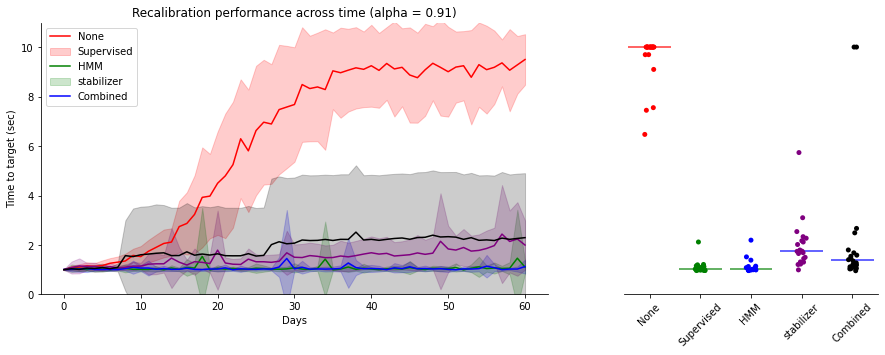

In [12]:
figSize(5, 15)
from lineplots import plotsd
import seaborn as sns 
figSize(5, 15)

labels = ['None', 'Supervised', 'HMM', 'stabilizer', 'Combined']
colors = ['r', 'g', 'b', 'purple', 'k',]

#labels = ['None', 'Supervised', 'subspace']
#colors = ['r', 'g', 'b']

days     = np.linspace(0, (base_opts['days_between'] + 1) * base_opts['n_sessions'], base_opts['n_sessions'] + 1)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})

# plot data across time
plt.axes(axs[0])
for i, label in enumerate(labels):
    plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = False)

axs[0].legend(labels, loc = 'upper left')
axs[0].set_title('Recalibration performance across time (alpha = ' + str(base_opts['shrinkage']) + ')')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Time to target (sec)')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylim([0, 11])

# and now the results on final day
plt_data = [session_scores[:, -1, i].flatten() for i in range(len(labels))]
cmap     = dict(zip(np.arange(len(labels)), colors))
sns.stripplot(data = plt_data, palette = cmap, ax = axs[1])

sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=plt_data, showfliers=False, showbox=False, showcaps=False, ax=axs[1])

for i, line in enumerate(axs[1].get_lines()):
    line.set_color(cmap[np.floor(i / len(colors))])

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_yticks([])
axs[1].set_xticklabels(labels, rotation = 45)
axs[1].set_ylim([0, 11])

plt.savefig(fig_path + 'simulator/combined_approach', format = 'pdf')
plt.show()

In [ ]:
import scipy

for i in range(len(labels)):
    print('--------------', labels[i], '-----------------')
    print('TTT, mean +- SD: ', np.mean(plt_data[i]), np.std(plt_data[i]))
    print('\n')
    for j in range(len(labels)):
        if j > i:
            print('{} and {}: \n'.format(labels[i], labels[j]), scipy.stats.ranksums(plt_data[i], plt_data[j]) )
            print('\n')
